In [1]:
# Conversion libraries and Seurat
library(SeuratDisk)
library(SeuratData)
library(SeuratObject)
library(Seurat)
library(Signac)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::reduce() masks Signac::reduce()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [2]:
# Parameters
NN <- 25

In [3]:
# File names for saving
DIR = "/cellar/users/aklie/projects/igvf/beta_cell_networks/bin/infer_grns/hdwgcna/combined"
NAME=paste0(NN, "_neighbors")
OUT= file.path(DIR, "network_construction", NAME)
OUT

[1] "/cellar/users/aklie/projects/igvf/beta_cell_networks/bin/infer_grns/hdwgcna/combined/network_construction/25_neighbors"

# Data Loading

In [21]:
# Load processed Seurat object
RDS_FILE = file.path(DIR, "data", "multiome_ctrl_w_primary_ND_integrated_NormalizeData_RPCA_sub_w_clusters.rds")
RDS_FILE

[1] "/cellar/users/aklie/projects/igvf/beta_cell_networks/bin/infer_grns/hdwgcna/combined/data/multiome_ctrl_w_primary_ND_integrated_NormalizeData_RPCA_sub_w_clusters.rds"

In [22]:
# Load in the seurat object from the cleaned version
seurat_merged <- readRDS(RDS_FILE)

In [23]:
# Check it!
seurat_merged

An object of class Seurat 
38601 features across 17852 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

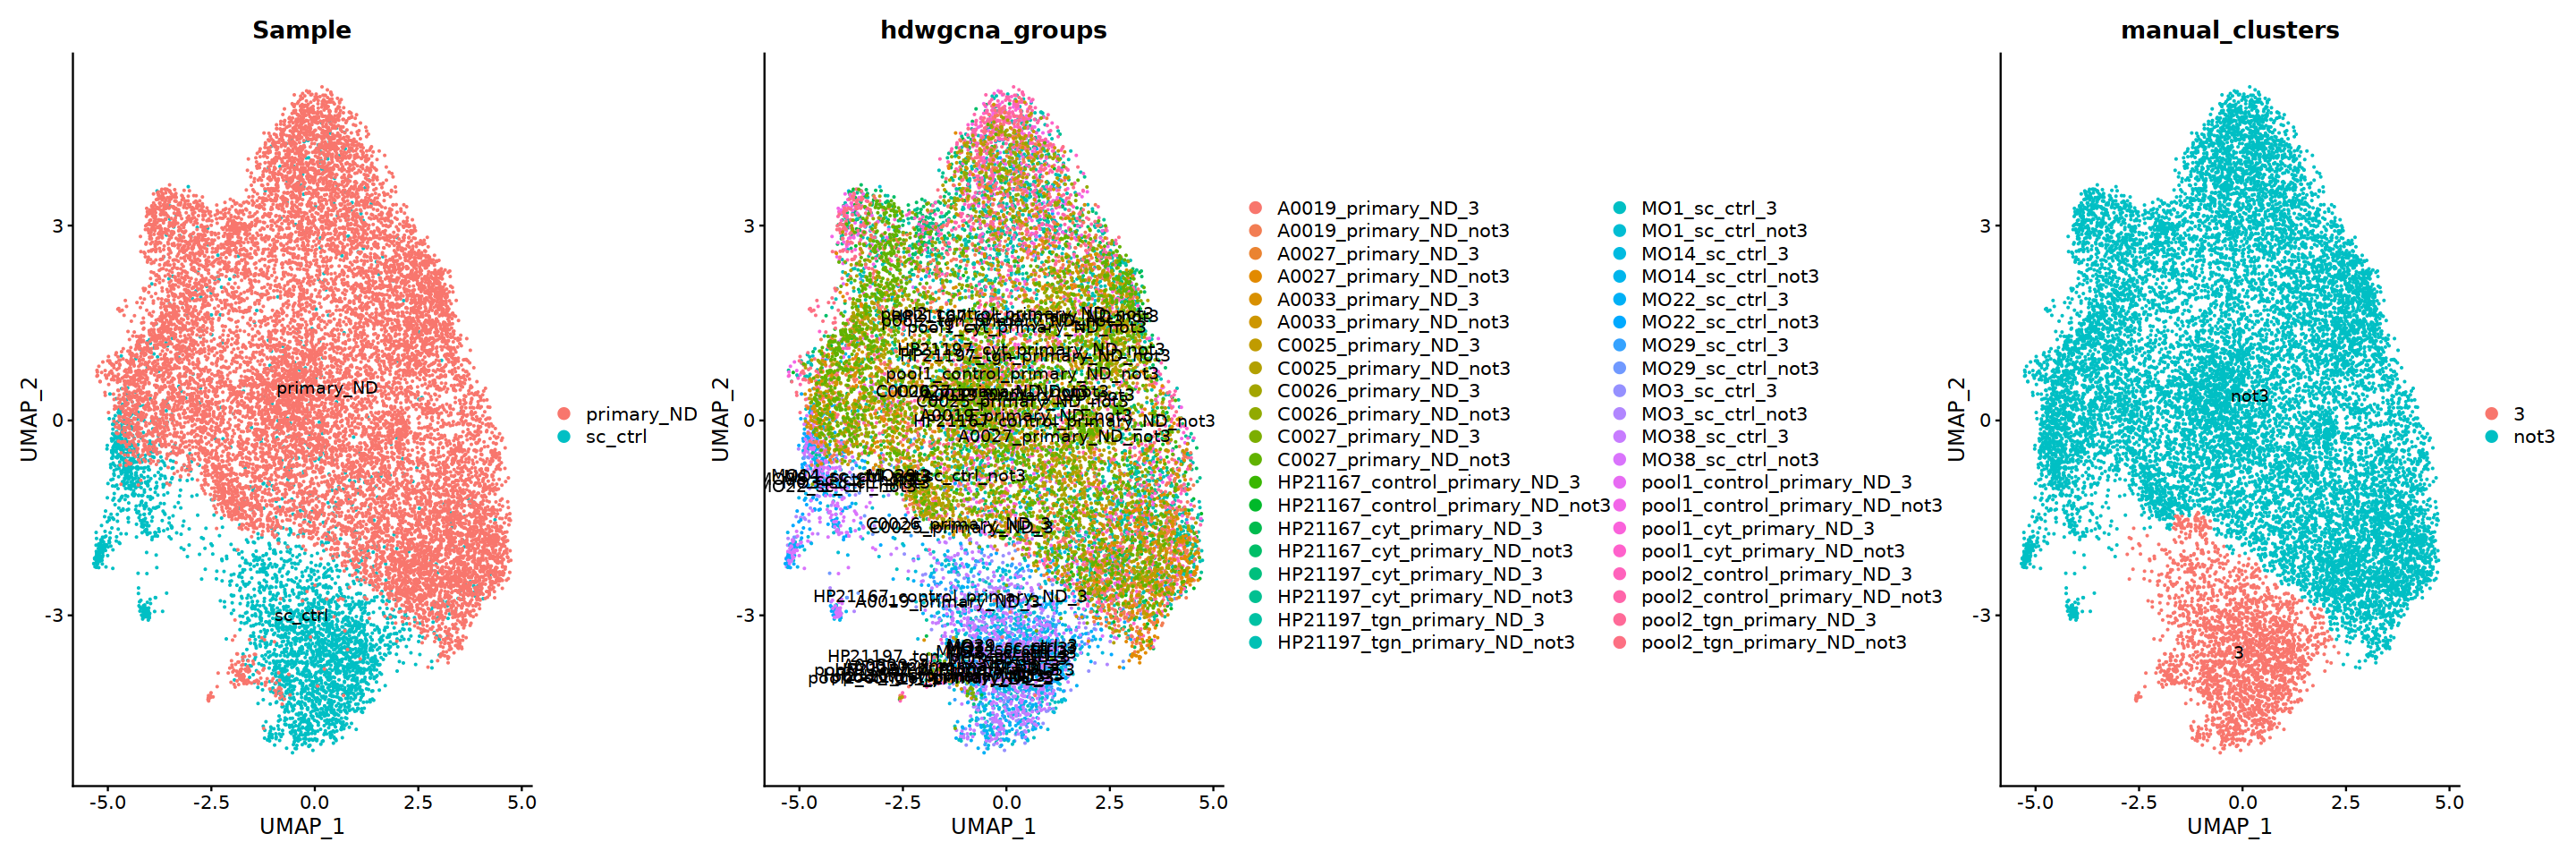

In [27]:
# Double check the umaps for clustering
options(repr.plot.width=24, repr.plot.height=8)
p1 <- DimPlot(seurat_merged, group.by='Sample', raster=FALSE, label=TRUE)
p2 <- DimPlot(seurat_merged, group.by='hdwgcna_groups', raster=FALSE, label=TRUE)
p3 <- DimPlot(seurat_merged, group.by='manual_clusters', raster=FALSE, label=TRUE)
p1 + p2 + p3

In [28]:
# Decide whether or not you want to use the integrated assay or the RNA assay to get features
DefaultAssay(seurat_merged) <- "RNA"

In [29]:
# Grab features to use for WGCNA
seurat_merged <- SetupForWGCNA(
  seurat_merged,
  #features = VariableFeatures(seurat_merged),
  gene_select = "fraction",
  fraction = 0.05,
  wgcna_name = 'sc_vs_primary'
)

In [30]:
length(seurat_merged@misc$sc_vs_primary$wgcna_genes)

[1] 9247

In [37]:
# construct metacells:
seurat_merged <- MetacellsByGroups(
  seurat_merged,
  group.by = c("sample", "Sample", "manual_clusters"),
  k = NN,
  max_shared = 12,
  min_cells = 25,
  target_metacells = 1000,
  assay = "RNA",
  slot = "counts",
  reduction = 'pca',
  ident.group = 'Sample',
)
seurat_merged <- NormalizeMetacells(seurat_merged)

Warning message in MetacellsByGroups(seurat_merged, group.by = c("sample", "Sample", :
“Removing the following groups that did not meet min_cells: A0027#primary_ND#3, A0033#primary_ND#3, C0026#primary_ND#3, HP21167_control#primary_ND#3, HP21167_cyt#primary_ND#3, HP21197_cyt#primary_ND#3, HP21197_tgn#primary_ND#3, pool1_control#primary_ND#3, pool1_cyt#primary_ND#3, pool2_control#primary_ND#3, pool2_tgn#primary_ND#3”
Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“Metacell failed”
Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“Metacell failed”


[1] "done making metacells"
[1] 27
[1] "metacell shape"


In [38]:
table(seurat_merged@misc$sc_vs_primary$wgcna_metacell_obj$Sample)


primary_ND    sc_ctrl 
      7352       1523 

In [39]:
# setup expression matrices for each species in astrocytes
seurat_merged <- SetMultiExpr(
  seurat_merged,
  multi.group.by = "Sample",
  assay = "RNA",
  slot = "data"
)

In [40]:
seurat_merged@misc$sc_vs_primary$multiExpr$primary_ND$data[1:6, 1:6]

,LINC01409,LINC01128,SAMD11,NOC2L,C1orf159,SDF4
A0019#primary_ND#not3_1,0.1008410,0.7231952,0.1008410,0.19243820,0.0000000,0.1008410
A0019#primary_ND#not3_2,0.1838256,0.4084709,0.4733845,0.09613083,0.1838256,0.3390491
A0019#primary_ND#not3_3,0.2608523,0.4675455,0.7502998,0.07186380,0.0000000,0.1389076
A0019#primary_ND#not3_4,0.4702788,0.4276992,0.2878655,0.12524948,0.1252495,0.0000000
A0019#primary_ND#not3_5,0.2474943,0.3839147,0.4457264,0.00000000,0.2474943,0.0000000
A0019#primary_ND#not3_6,0.4098021,0.6630381,0.7690703,0.06986178,0.0000000,0.1351600


In [41]:
seurat_merged@misc$sc_vs_primary$multiExpr$sc_ctrl$data[1:6, 1:6]

,LINC01409,LINC01128,SAMD11,NOC2L,C1orf159,SDF4
MO1#sc_ctrl#3_1,0.2129823,0.2858498,0.1380258,0.07445011,0.12340969,0.15205725
MO1#sc_ctrl#3_2,0.1754830,0.3859500,0.1502707,0.13136872,0.08780921,0.09023337
MO1#sc_ctrl#3_3,0.2757352,0.5877059,0.1241098,0.06051826,0.01008412,0.05949377
MO1#sc_ctrl#3_4,0.2563021,0.3871954,0.1286710,0.13069902,0.04896545,0.13231244
MO1#sc_ctrl#3_5,0.1837587,0.3409805,0.1125182,0.07387193,0.19808446,0.15967507
MO1#sc_ctrl#3_6,0.1342942,0.2523866,0.1232193,0.11997881,0.10806935,0.20114117


In [42]:
# identify soft power thresholds
seurat_merged <- TestSoftPowersConsensus(seurat_merged)

[1] "sc_ctrl"
pickSoftThreshold: will use block size 4840.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4840 of 9243


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 4841 through 9243 of 9243


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1    0.179  13.10          0.953 4.66e+03  4.67e+03 4940.00
2      2    0.460 -11.10          0.848 2.40e+03  2.37e+03 2890.00
3      3    0.712  -8.46          0.855 1.27e+03  1.22e+03 1810.00
4      4    0.904  -6.90          0.959 6.80e+02  6.39e+02 1190.00
5      5    0.942  -5.55          0.980 3.73e+02  3.38e+02  811.00
6      6    0.947  -4.52          0.983 2.09e+02  1.81e+02  573.00
7      7    0.943  -3.86          0.985 1.19e+02  9.78e+01  415.00
8      8    0.946  -3.37          0.989 6.97e+01  5.35e+01  308.00
9      9    0.949  -3.01          0.994 4.16e+01  2.96e+01  233.00
10    10    0.947  -2.76          0.996 2.54e+01  1.65e+01  178.00
11    12    0.936  -2.42          0.995 1.01e+01  5.27e+00  109.00
12    14    0.930  -2.21          0.994 4.41e+00  1.74e+00   69.40
13    16    0.936  -2.03          0.997 2.07e+00  5.93e-01   45.60
14    18    0.936  -1.92          0.990 1.04e+00  2.05e-01   3

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 4841 through 9243 of 9243


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1 0.350000 10.200          0.920 4.79e+03  4.82e+03 5330.00
2      2 0.000332  0.136          0.960 2.53e+03  2.53e+03 3240.00
3      3 0.252000 -2.720          0.949 1.37e+03  1.35e+03 2060.00
4      4 0.552000 -3.420          0.954 7.51e+02  7.23e+02 1360.00
5      5 0.749000 -3.670          0.977 4.21e+02  3.91e+02  930.00
6      6 0.830000 -3.560          0.983 2.40e+02  2.15e+02  653.00
7      7 0.858000 -3.380          0.983 1.40e+02  1.21e+02  469.00
8      8 0.863000 -3.250          0.977 8.27e+01  6.82e+01  343.00
9      9 0.883000 -3.040          0.983 5.00e+01  3.90e+01  255.00
10    10 0.874000 -2.960          0.978 3.08e+01  2.26e+01  193.00
11    12 0.872000 -2.730          0.979 1.23e+01  7.75e+00  114.00
12    14 0.887000 -2.500          0.990 5.33e+00  2.76e+00   70.40
13    16 0.894000 -2.310          0.993 2.48e+00  1.01e+00   44.90
14    18 0.893000 -2.190          0.993 1.23e+00  3.77e-01   2

[1] "here"
[1] 1
[1] 6
# A tibble: 6 × 7
  Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
  <dbl>    <dbl>  <dbl>          <dbl>   <dbl>     <dbl>  <dbl>
1     1 0.350    10.2            0.920   4786.     4817.  5332.
2     2 0.000332  0.136          0.960   2532.     2534.  3235.
3     3 0.252    -2.72           0.949   1366.     1346.  2057.
4     4 0.552    -3.42           0.954    751.      723.  1358.
5     5 0.749    -3.67           0.977    421.      391.   930.
6     6 0.830    -3.56           0.983    240.      215.   653.
[1] 2
[1] 4
# A tibble: 6 × 7
  Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
  <dbl>    <dbl>  <dbl>          <dbl>   <dbl>     <dbl>  <dbl>
1     1    0.179  13.1           0.953   4663.     4666.  4945.
2     2    0.460 -11.1           0.848   2404.     2369.  2891.
3     3    0.712  -8.46          0.855   1266.     1218.  1805.
4     4    0.904  -6.90          0.959    680.      639.  1186.
5     5    0.942  -5.55          

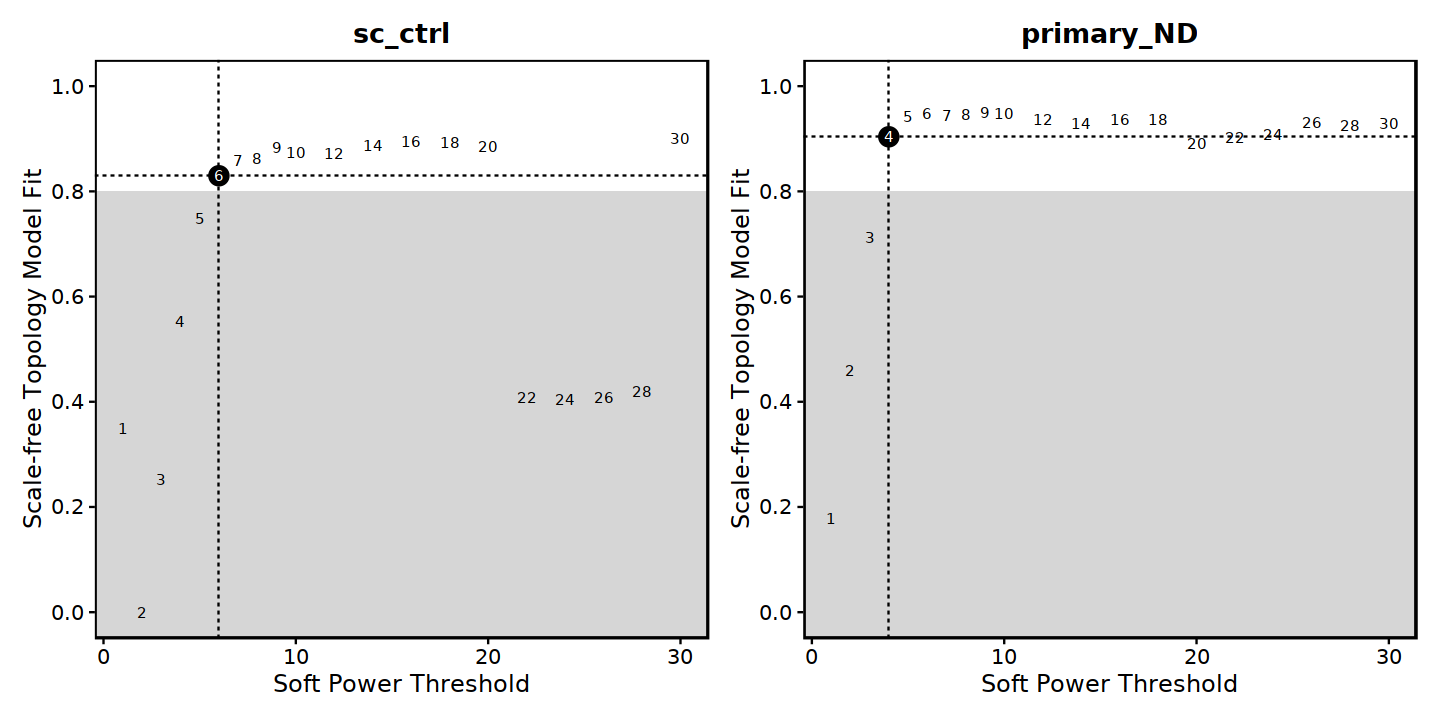

In [43]:
# plot soft power results
options(repr.plot.width=12, repr.plot.height=6)
plot_list <-  PlotSoftPowers(seurat_merged)
consensus_groups <- unique(seurat_merged$Sample)
p_list <- lapply(1:length(consensus_groups), function(i){
  cur_group <- consensus_groups[[i]]
  plot_list[[i]][[1]] + ggtitle(paste0(cur_group)) + theme(plot.title=element_text(hjust=0.5))
})
wrap_plots(p_list, ncol=2)

In [44]:
# consensus network analysis
seurat_merged <- ConstructNetwork(
  seurat_merged,
  soft_power=c(6, 4),
  consensus=TRUE,
  tom_name = "sc_vs_primary_RNA_genes",
)

 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


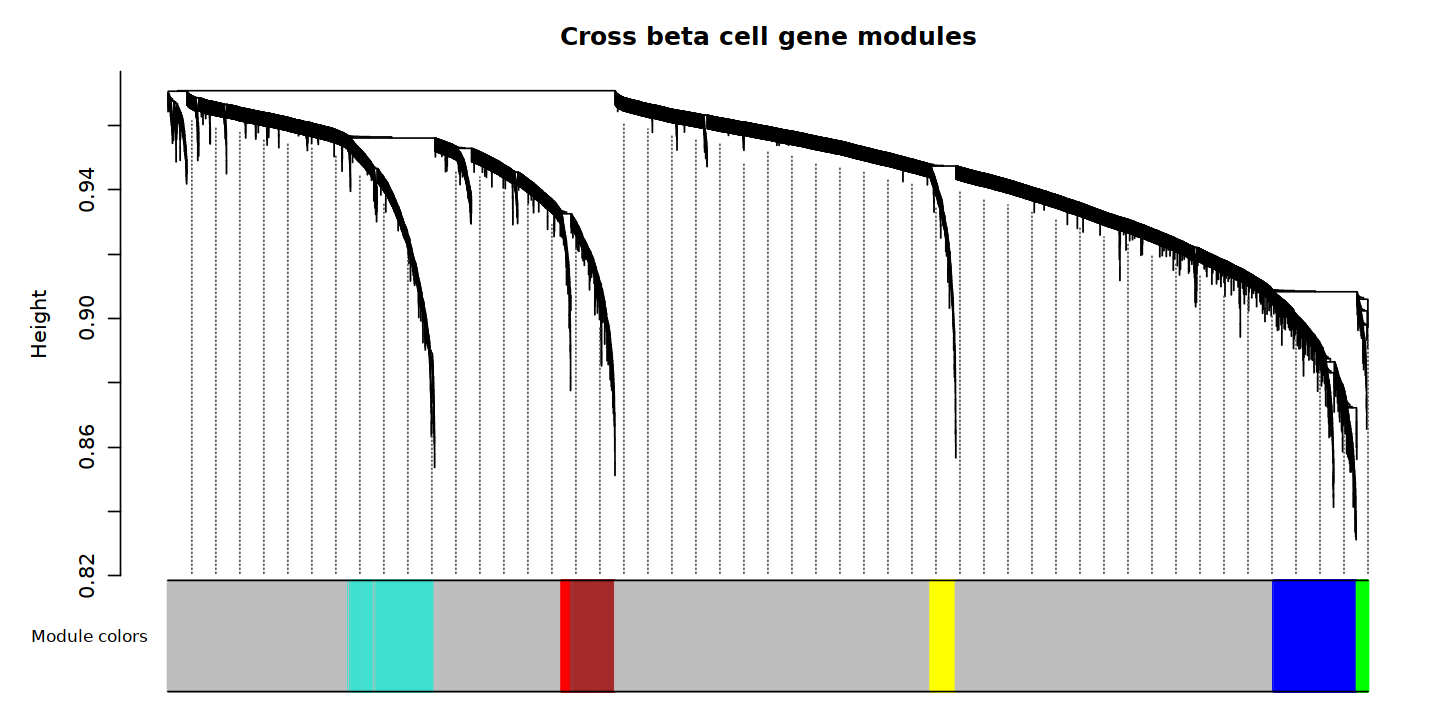

In [45]:
# plot the dendrogram
PlotDendrogram(seurat_merged, main='Cross beta cell gene modules')

In [46]:
seurat_merged$Sample <- as.factor(seurat_merged$Sample)

In [47]:
# need to run ScaleData first or else harmony throws an error:
seurat_merged <- ScaleData(seurat_merged, features=VariableFeatures(seurat_merged))

Centering and scaling data matrix



In [48]:
# compute all MEs in the full single-cell dataset
seurat_merged <- ModuleEigengenes(
 seurat_merged,
 group.by.vars=c("sample", "Sample", "manual_clusters")
)

[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”
pcagrey_ 1 
Positive:  KALRN, NTM, ADARB2, TENM2, CNTNAP2, NPSR1-AS1, HS3ST5, KHDRBS2, ADCY2, AC092969.1 
	   AC112770.1, LINC01456, CCDC144NL-AS1, ST6GALNAC5, AL138694.1, KIAA1549L, DSCAM, DLGAP1, HCN1, CDH8 
	   AC109466.1, AL442636.1, KCNT2, GHR, SPOCK3, ARHGAP6, PLPPR1, MYO10, ABTB2, MIR217HG 
Negative:  MEIS2, MEG3, AGBL4, CNTN5, SYNE2, NEAT1, LDLRAD4, INS, VWDE, IER3 
	   VMP1, NR3C2, PCDH17, DNM3, AHI1, GPM6A, ESR1, SLCO5A1, NAV2, ATP1B1 
	   N4BP2L2, SGMS2, MAP3K5, LINC01473, PDE8B, STXBP5-AS1, UMAD1, RHOBTB3, G6PC2, LINC01725 
pcagrey_ 2 
Positive:  IER3, KALRN, ADARB2, NTM, AC112770.1, TENM2, AC109466.1, HS3ST5, CNTNAP2, GHR 
	   ADCY2, DLGAP1, PLD5, LINC01456, AL121917.1, CCDC144NL-

[1] "yellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcayellow_”
pcayellow_ 1 
Positive:  MALAT1, TMOD1, DPP6, PLCG2, PITPNC1, MIRLET7BHG, SLC6A6, DGCR9, C5orf17, TNS1 
	   SLC7A5, SAMD11, L3MBTL4, KIF26B, IL17RB, KCNK3, LINC00511, ST14, GNAS, PCBP3 
	   WARS, ZFYVE28, TRIM56, APOL2, FLOT1, RFFL, RGS9, SMARCD3, PARP14, WNT9A 
Negative:  CAMK1D, MIAT, PLXNA2, ZDHHC14, LRRN2, ATXN7L1, GRK5, AL050309.1, AC233296.1, CTBP2 
	   SSBP3, FSIP2, VLDLR-AS1, ISL1, NTNG2, LINC01146, SH3PXD2A, GALNT14, LRFN2, CACNA1C 
	   PDE3B, KLHL29, SYT17, EVL, ZNRF1, HDAC4, MYO3A, PDE9A, IQSEC1, WWC1 
pcayellow_ 2 
Positive:  MIAT, LRRN2, CAMK1D, PLXNA2, AC233296.1, GRK5, ATXN7L1, ISL1, CTBP2, SYT17 
	   VLDLR-AS1, AL050309.1, ZDHHC14, FSIP2, KIAA0408, NTNG2, ZNF710, ZFHX2, S

[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”
pcablue_ 1 
Positive:  UCHL1, HSP90AA1, MYDGF, NR1D1, PDIA3, FAM102A, GNG7, DGKZ, CDK5RAP3, AC025159.1 
	   MTCH1, AMPD3, ATP5MC2, BAIAP3, PDXK, INTS11, ZFAND5, LONP1, RAB1A, RRP12 
	   CWC25, STX5, P4HB, NAPA, SEC61A1, BAIAP2, CCNL1, CCAR2, PRPF6, ACADVL 
Negative:  HNF1A-AS1, PTPRN2, CACNA1B, DENND2A, STXBP5L, VIL1, LINC00342, KIF12, KCNH6, VAC14 
	   MCF2L, RGS12, LSS, CLIP2, LLGL2, ABAT, C20orf194, PTPRS, DOP1B, SVOP 
	   ACAP3, PI4KA, HECTD4, TTC3, NINL, ANKRD36C, SREBF2, CERS4, CRTC1, FARP2 
pcablue_ 2 
Positive:  HNF1A-AS1, VIL1, KIF12, DENND2A, KCNH6, RGS12, PTPRS, RGL3, ELAVL3, MCF2L 
	   DOCK6, CLIP2, CACNA1B, ARID3A, MYO15B, LINC00342, CRTC1, EXOC7, RXRA, DOP1B 
	   OSBP2, VAC14, NP

[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”
pcaturquoise_ 1 
Positive:  GPC6, CHST9, SEMA3A, LHFPL6, NBEA, CCSER1, PDE4D, CADPS, PRICKLE2, KCNMB2 
	   AC104041.1, TENM4, FGF12, A1CF, RUNX1T1, CACNA2D1, PHACTR1, CASC9, CTNNA2, AQP4-AS1 
	   KCNB2, UTRN, SCN3A, AC009315.1, PBX3, NRXN1, DACH1, TMEM196, TOX3, HS6ST3 
Negative:  ZNF385D, HDAC9, MEG8, FNDC3B, IMMP2L, ZBTB20, NLGN1, LIMCH1, HIVEP2, MAGI1 
	   ID1, NFIA, TRIM9, LUCAT1, TRPM3, DPH6-DT, BTG3, ZNF385D-AS2, ARRDC3, AC017101.1 
	   NRG1, CRADD, IGSF11, AC079921.1, PLOD2, THRB, AC107021.1, AL391840.3, DLG2, ALG13-AS1 
pcaturquoise_ 2 
Positive:  ZNF385D, LIMCH1, TRPM3, ZBTB20, HDAC9, NLGN1, NRG1, FAM155A, IMMP2L, MEG8 
	   EFNA5, BMP5, DLG2, SOX6, MAGI2, HIVEP2, FNDC3B

[1] "green"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreen_”
pcagreen_ 1 
Positive:  RTN4RL1, CMIP, USH1C, HNF4A, PDZD2, KCNQ1OT1, SIPA1L3, GIPR, FTCD, GSE1 
	   VWA5B2, FBXO17, DPYSL2, PVALEF, ABCC8, RAP1GAP2, VAV2, CACNA1A, TNRC18, PCNT 
	   DNMT3A, NSD2, LARP1, PTPRF, EPB41L1, SNAP91, LRP5, HCG17, INTS3, SOGA1 
Negative:  NFIC, NPTX2, STX1A, SLC17A5, CAMKK1, UBE4B, CPT1A, RASA4B, HOOK2, XPO1 
	   KANTR, AC106795.3, ECHDC2, TNK2, KDM2B, AC005089.1, D2HGDH, SYT7, ANKRD27, CACNA1H 
	   DNM1, UNK, TPT1-AS1, GIPC1, KIAA1324, RAB26, PTPRJ, C1orf127, TLE2, DHTKD1 
pcagreen_ 2 
Positive:  NPTX2, ABCC8

[1] "brown"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcabrown_”
pcabrown_ 1 
Positive:  PLXDC2, DPP10, SGCD, PIP5K1B, AL031428.1, PLPPR5, GALNT13, AUTS2, ITGB3BP, AC068282.1 
	   ECHDC1, ZC2HC1A, OXCT1, DCUN1D5, EIF3H, POT1, CDYL, USP6NL, ATE1, EPM2A 
	   ATG5, NAF1, PIP4P2, CHMP2B, FBXO30, CNOT6L, TBCA, FAM13C, TBL1XR1, UBE2D1 
Negative:  PSMD1, CRY1, WDFY3, UBR3, CUL3, TNKS, PTBP2, NCKAP1, PSMB7, TAX1BP1 
	   ARIH1, MARCH6, GIGYF2, RICTOR, CAPN7, SNX13, WAC, MAP3K2, VAPA, FTO 
	   FAR1, TM9SF3, MYEF2, OLA1, PPM1A, PPP2R2A, SKP1, UTY, ZC3H6, PPP1CB 
pcabrown_ 2 
Positive:  PAM, CRY1, DYNC1I1, PPP1CB, ZC3H6, ITM2B, LUC7L2, TMEM65, CIR1, FAM172A 
	   HBP1, ATXN1, CENPC, RSRC1, SKP1, JMJD1C, LINC01619, SMURF1, SIK3, PSMB7 
	   FTO, ZNRF2, RAB18, ACSL3, UB

[1] "red"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcared to pcared_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcared_”
pcared_ 1 
Positive:  ROBO2, LINC02315, SMYD3, HECW2, HDAC2-AS2, MMP16, ARHGEF28, RCAN2, MLLT3, BCKDHB 
	   FOCAD, MACROD2, AC078881.1, KCNH7, GRB14, PHLDB2, STAU2, GNAI1, ZMYM2, AL355612.1 
	   ATP2B1, GRAMD2B, DENND1A, VPS8, SMAD2, DOCK7, APP, C15orf41, SPAG16, GRM1 
Negative:  SRBD1, ANO5, FGF14, PIGN, AC104123.1, SUCO, CPEB4, AC021231.1, SH3GL2, PDCD4 
	   PLEKHF2, CNTN1, FOXN2, FER, URI1, NLK, TPD52, PPP1R12B, TBC1D4, HMGCLL1 
	   BTBD3, ZNF148, SLC4A7, FSIP2-AS1, CCDC91, GALNT11, MPP7, MPP6, AC046134.2, TMCC1 
pcared_ 2 
Positive:  LINC

In [49]:
# compute eigengene-based connectivity (kME):
seurat_merged <- ModuleConnectivity(
  seurat_merged,
)

Warning message in bicor(datExpr, datME, , use = "p"):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


In [50]:
# Save the fully processed Seurat object to be used in all the other notebooks
saveRDS(seurat_merged, file=sprintf('%s_hdWGCNA_RNA_features.rds', NAME))

In [26]:
seurat_merged

An object of class Seurat 
38601 features across 17852 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

---

# Scratch